### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [15]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-01 20:22:49--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-11-01 20:22:50 (9.11 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 26, 26, ..., 60, 56, 64],
       [83,  1, 60, ..., 56,  7,  0],
       [83, 55, 45, ..., 56, 53,  1],
       ...,
       [83, 45, 56, ..., 50, 58, 73],
       [83,  7,  0, ..., 56, 53, 63],
       [83,  7,  0, ..., 50, 54,  0]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
# your beautiful experiments here

Epoch [10/1000], Loss: 3.1227
Epoch [20/1000], Loss: 2.7882
Epoch [30/1000], Loss: 2.6588
Epoch [40/1000], Loss: 2.5847
Epoch [50/1000], Loss: 2.4888
Epoch [60/1000], Loss: 2.4527
Epoch [70/1000], Loss: 2.4309
Epoch [80/1000], Loss: 2.3882
Epoch [90/1000], Loss: 2.3297
Epoch [100/1000], Loss: 2.3072
Epoch [110/1000], Loss: 2.2934
Epoch [120/1000], Loss: 2.2778
Epoch [130/1000], Loss: 2.2497
Epoch [140/1000], Loss: 2.2500
Epoch [150/1000], Loss: 2.2325
Epoch [160/1000], Loss: 2.2194
Epoch [170/1000], Loss: 2.1807
Epoch [180/1000], Loss: 2.1596
Epoch [190/1000], Loss: 2.1537
Epoch [200/1000], Loss: 2.1566
Epoch [210/1000], Loss: 2.0938
Epoch [220/1000], Loss: 2.0772
Epoch [230/1000], Loss: 2.0992
Epoch [240/1000], Loss: 2.0668
Epoch [250/1000], Loss: 2.0807
Epoch [260/1000], Loss: 2.0783
Epoch [270/1000], Loss: 2.0688
Epoch [280/1000], Loss: 2.0008
Epoch [290/1000], Loss: 1.9776
Epoch [300/1000], Loss: 2.0447
Epoch [310/1000], Loss: 2.0434
Epoch [320/1000], Loss: 2.0223
Epoch [330/1000],

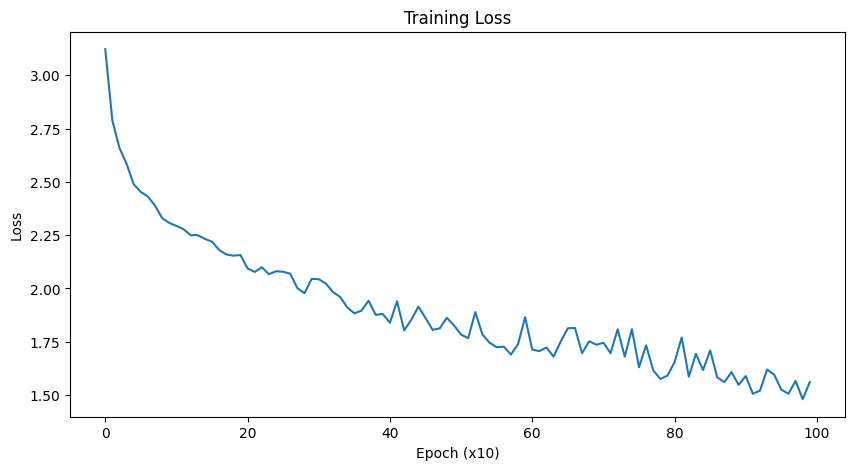

In [86]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)

        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)

        if hidden is None:
            hidden = torch.zeros(1, batch_size, self.hidden_size, device=x.device)

        embedded = self.embedding(x)  # (batch_size, sequence_length, hidden_size)

        output, hidden = self.rnn(embedded, hidden)

        output = self.fc(output)  # (batch_size, sequence_length, output_size)

        return output, hidden

def train_rnn(model, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        batch = next(generate_chunk())
        x = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
        y = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)

        output, hidden = model(x)

        output = output.view(-1, num_tokens)
        y = y.view(-1)

        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / num_batches
            losses.append(avg_loss)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses

model = VanillaRNN(
    input_size=num_tokens,
    hidden_size=256,
    output_size=num_tokens
).to(device)

losses = train_rnn(model, num_epochs=1000)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch (x10)')
plt.ylabel('Loss')
plt.show()

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

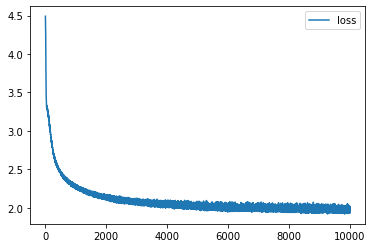

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [87]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. higher temperature produces more chaotic outputs,
                       smaller temperature converges to the single most likely output
    '''

    char_rnn.eval()

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = None

    while x_sequence.size(1) < max_length:
        with torch.no_grad():
            output, hidden = char_rnn(x_sequence, hidden)

        logits = output[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)

        next_char_idx = torch.multinomial(probs, 1)

        x_sequence = torch.cat([x_sequence, next_char_idx], dim=1)

    return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [88]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правил на вас кому венялю и молыник,
на светел,
но всё, —



xxxii

как не может,
невольна вод небесных милый,
но ленский; с урев,
как барика;
нас проходит с евгений.
он очариной
ее предрагает,
или хоем был долго милой,
то попросто счастливый,
что неозвесть барок уж описала
тверя возруженный дрожный друг один
благеет евгений
о смешно знать на том, усы одно;
приятные день:
то сарах очи;
и я рукой.
вдруг одна чувством уж едины, погружает своен;
увиже;
зверь, он уж о ты, к 


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [89]:
seed_phrase = ' мой дядя самых честных правил'

In [94]:
generated_phrases = [
     generate_sample(
         model,
         ' мой дядя самых честных правил',
         max_length=501,
         temperature=0.8
     ).replace('<sos>', '')
     for _ in range(10)
 ]

In [95]:
for p in generated_phrases:
  print(len(p))

500
500
500
500
500
500
500
500
500
500


In [96]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!